In [175]:
import glob
import os
import warnings
from datetime import datetime

import cmocean.cm as cmo
import dask
import holoviews as hv
import hvplot.pandas
import hvplot.xarray
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import seaborn
import xarray as xr
from matplotlib import patches
from skimage import io
from skimage.measure import label, regionprops, regionprops_table

# load custom colormaps
from may19_2013_obs_analysis import cmap_extent_density_b13, cmap_footprint_b13
from may19_2013_obs_analysis.zdr_flash_panel_plots import plot_flash_zdr
from may19_2013_obs_analysis.utils import npdt_to_datetime
from matplotlib import dates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

seaborn.set(style="ticks")


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["axes.labelsize"] = 18
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 2

In [40]:
# original code for interactive xarray compatibility available at https://anaconda.org/philippjfr/xarray_interactive/notebook

# Also, look at this open issue in xarray github repo: https://github.com/pydata/xarray/issues/3709

import abc

from panel.layout import Column, HSpacer, Row, VSpacer


class Interactive:

    __metaclass__ = abc.ABCMeta

    _fig = None

    def __init__(
        self,
        da,
        transform=None,
        plot=False,
        depth=0,
        loc="top_left",
        center=False,
        dmap=False,
        eager=True,
    ):
        self._name = da.name
        self._da = da
        self._method = None
        if transform is None:
            self._transform = hv.dim(self._name)
        else:
            self._transform = transform
        self._plot = plot
        self._depth = depth
        self._loc = loc
        self._center = center
        self._dmap = dmap
        self._eager = eager
        if eager:
            ds = hv.Dataset(self._da)
            self._current = self._transform.apply(ds, keep_index=True, compute=False)
        else:
            self._current = self._da

    @property
    def _params(self):
        return [v for k, v in self._transform.params.items() if k != "ax"]

    @property
    def _callback(self):
        @pn.depends(*self._params)
        def evaluate(*args, **kwargs):
            obj = self._transform.apply(
                hv.Dataset(self._da), keep_index=True, compute=False
            )
            if self._plot:
                return Interactive._fig
            else:
                return obj

        return evaluate

    def clone(
        self, transform=None, plot=None, loc=None, center=None, dmap=None, eager=None
    ):
        plot = self._plot or plot
        transform = transform or self._transform
        loc = self._loc if loc is None else loc
        center = self._center if center is None else center
        dmap = self._dmap if dmap is None else dmap
        eager = self._eager if eager is None else eager
        depth = self._depth + 1
        return Interactive(self._da, transform, plot, depth, loc, center, dmap, eager)

    def __dir__(self):
        return [d for d in dir(self._current) if d[0] != "_"]

    def __getattr__(self, name):
        if name in dir(self):
            self._method = name
            self.__doc__ = getattr(self._da, name).__doc__
            return self
        raise AttributeError(name)

    def __call__(self, *args, **kwargs):
        if self._method is None:
            if self._depth == 0:
                return self.clone(*args, **kwargs)
            raise AttributeError
        method = type(self._transform)(self._transform, self._method, accessor=True)
        return self.clone(method(*args, **kwargs))

    def _repr_mimebundle_(self, include=[], exclude=[]):
        return self.layout()._repr_mimebundle_()

    def layout(self):
        widget_box = pn.Column(
            *(
                p.owner
                for p in self._transform.params.values()
                if isinstance(p.owner, pn.widgets.Widget)
            )
        )
        panel = self.dmap() if self._dmap else self.panel()
        loc = self._loc
        if loc in ("left", "right"):
            widgets = Column(VSpacer(), widget_box, VSpacer())
        elif loc in ("top", "bottom"):
            widgets = Row(HSpacer(), widget_box, HSpacer())
        elif loc in ("top_left", "bottom_left"):
            widgets = Row(widget_box, HSpacer())
        elif loc in ("top_right", "bottom_right"):
            widgets = Row(HSpacer(), widget_box)
        elif loc in ("left_top", "right_top"):
            widgets = Column(widget_box, VSpacer())
        elif loc in ("left_bottom", "right_bottom"):
            widgets = Column(VSpacer(), widget_box)
        center = self._center
        if not widgets:
            if center:
                components = [HSpacer(), panel, HSpacer()]
            else:
                components = [panel]
        elif center:
            if loc.startswith("left"):
                components = [widgets, HSpacer(), panel, HSpacer()]
            elif loc.startswith("right"):
                components = [HSpacer(), panel, HSpacer(), widgets]
            elif loc.startswith("top"):
                components = [
                    HSpacer(),
                    Column(widgets, Row(HSpacer(), panel, HSpacer())),
                    HSpacer(),
                ]
            elif loc.startswith("bottom"):
                components = [
                    HSpacer(),
                    Column(Row(HSpacer(), panel, HSpacer()), widgets),
                    HSpacer(),
                ]
        else:
            if loc.startswith("left"):
                components = [widgets, panel]
            elif loc.startswith("right"):
                components = [panel, widgets]
            elif loc.startswith("top"):
                components = [Column(widgets, panel)]
            elif loc.startswith("bottom"):
                components = [Column(panel, widgets)]
        return Row(*components)

    def plot(self, *args, **kwargs):
        @pn.depends()
        def get_ax():
            from matplotlib.backends.backend_agg import FigureCanvas
            from matplotlib.pyplot import Figure

            Interactive._fig = fig = Figure()
            FigureCanvas(fig)
            return fig.subplots()

        kwargs["ax"] = get_ax
        transform = hv.dim(self._transform, "plot", accessor=True)
        return self.clone(transform(*args, **kwargs), plot=True)

    def eval(self):
        if self._eager:
            return self._current
        return self._callback()

    def hvplot(self, *args, **kwargs):
        transform = type(self._transform)(self._transform, "hvplot", accessor=True)
        return self.clone(transform(*args, **kwargs))

    def panel(self, **kwargs):
        return pn.panel(self._callback, **kwargs)

    def dmap(self):
        return hv.DynamicMap(self._callback)


xr.register_dataarray_accessor("interactive")(Interactive);

/anaconda3/envs/segmentation/lib/python3.6/site-packages/ipykernel_launcher.py:183: AccessorRegistrationWarning: registration of accessor <class '__main__.Interactive'> under name 'interactive' for type <class 'xarray.core.dataarray.DataArray'> is overriding a preexisting attribute with the same name.


In [41]:
# after manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [
    [3],
    [2],
    [2],
    [1, 2],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [5, 6],
    [2],
    [4, 5],
    [3, 4],
    [2, 3],
    [2, 3],
    [5, 6],
    [3],
    [4, 5],
    [3, 4],
    [3, 4],
    [1, 2],
    [3, 4],
    [6, 7, 9],
    [1, 2, 3],
    [3, 4, 5],
    [2, 3],
    [2, 3, 4, 5],
    [1, 2, 3],
    [1, 2],
    [2, 3],
    [2, 3],
    [1, 4],
    [1, 2],
    [1, 2],
    [2, 3],
    [1, 2],
    [3, 4, 5],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [42]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*tiff")
)

# rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
rad_files = sorted(
    glob.glob("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/*V06")
)
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [43]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for zdr column objects
# NOTE: These zdr column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/zdr/direct_array/*.tiff")
)


final_zdr_df = pd.DataFrame()
for i in range(len(segmented_files)):

    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label","equivalent_diameter"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_zdr_df = final_zdr_df.append(df_sel,)

In [44]:
final_zdr_df

,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,bbox_area,label,equivalent_diameter
time,,,,,,,,,
2013-05-19 20:02:36,0,32,15,8,57,28,2600,3,10.920988
2013-05-19 20:06:52,0,43,19,11,70,37,5346,2,11.593926
2013-05-19 20:11:07,0,38,25,8,78,41,5120,2,12.960907
2013-05-19 20:15:23,0,68,36,4,85,45,612,1,7.069538
2013-05-19 20:15:23,0,33,27,8,67,42,4080,2,12.213775
...,...,...,...,...,...,...,...,...,...
2013-05-19 22:27:38,0,113,222,7,134,235,1911,2,9.774699
2013-05-19 22:31:53,0,135,186,4,141,193,168,3,5.390202
2013-05-19 22:31:53,0,116,228,5,141,241,1625,4,9.821120


### Here's a small twist

regionprops_table() returns the properties for the entire array. So, in our case, when we used seg (segmented array; shape = (15,241,241)) </br>
it returned a one-size fits all bbox with the largest size (after iterating through all z-levels). Similarly, bbox_area gives the area of the </br>
entire bbox (or rather all pixels within the 3D bbox identified this way)

> Here's a workaround: We want the accurate bounding box at each z-level i.e., the box should only enclose the object at that z-level </br>
without accounting for whatever the bbox size is at altitudes above or below it


In [89]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)

mega_tt = pd.DataFrame()
for i in range(len(segmented_files)):
    cell_seg_reader = io.imread(segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(
        seg.shape[0]
    ):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "equivalent_diameter","label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :7].values,
                        index=[[dt_tmpstmps[i]], [obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:7],
                    )
                    
                    # equivalent diameter is float making the dtype for all columns in the dataframe as float
                    # bbox coordinates however are expected to have integer values in the code below
                    # converting all relevant column dtypes as int 
                    tmp2 = tmp2.astype({'bbox-0': 'int','bbox-1': 'int','bbox-2': 'int','bbox-3': 'int'})
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)

# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/questions/34050113/how-does-the-min-max-function-on-a-nested-list-work
final_bbox_data = mega_tt.reindex(np.arange(max(max(obj_interest))), level=1)

#### Now that we are ready with the bbox area info at each z-level, we can start calculating $Z_{DR}$ and $K_{DP}$ properties using xarray  


In [90]:
data = xr.open_mfdataset(
    "/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc",
    parallel=True,
)
data

<xarray.Dataset>
Dimensions:                      (nradar: 1, time: 42, x: 241, y: 241, z: 31)
Coordinates:
  * time                         (time) datetime64[ns] 2013-05-19T20:02:36.05...
  * x                            (x) float64 -7.5e+04 -7.45e+04 ... 4.5e+04
  * y                            (y) float64 0.0 500.0 ... 1.195e+05 1.2e+05
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
Dimensions without coordinates: nradar
Data variables:
    origin_latitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_longitude             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_altitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    projection                   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ProjectionCoordinateSystem   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    radar_latitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_longitude              (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_altitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_time                   (time, nradar) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_name                   (time, nradar) |S4 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity                 (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    velocity                     (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_reflectivity    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    spectrum_width               (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_phase           (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    cross_correlation_ratio      (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    norm_coherent_power          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    unfolded_differential_phase  (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    phidp                        (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    kdp                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    ROI                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KTLX
    original_container:  NEXRAD Level II
    vcp_pattern:         12

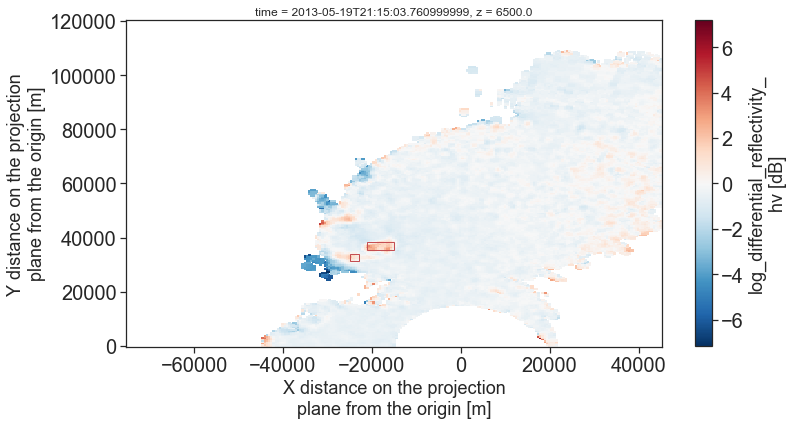

In [91]:
fig, ax = plt.subplots(figsize=(12, 6))

data["differential_reflectivity"].isel(time=17, z=13).plot()
rect1 = patches.Rectangle(
    (-25000, 31500), 2000, 2500, linewidth=1, edgecolor="r", facecolor="none"
)
rect2 = patches.Rectangle(
    (-21000, 35500), 6000, 3000, linewidth=1, edgecolor="r", facecolor="none"
)

ax.add_patch(rect1)
ax.add_patch(rect2)

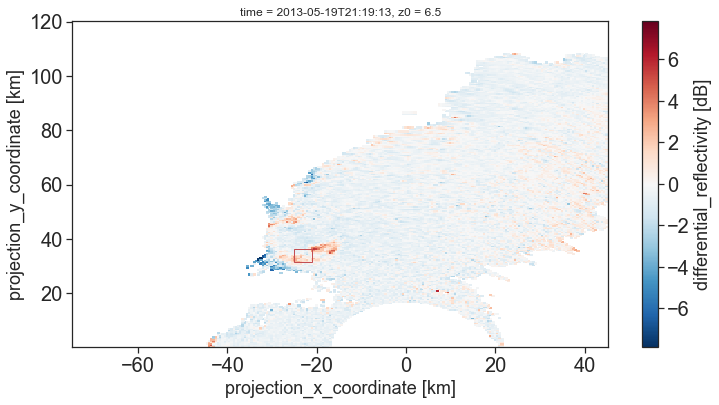

In [92]:
fig, ax = plt.subplots(figsize=(12, 6))

tt = xr.open_dataset(
    "/Users/ms/Desktop/RadxPid_KTLX_May192013/gridded_other_fields/20130519/small_domain/ncf_20130519_211913.nc"
)
tt["ZDR"].isel(time=0, z0=12).plot()

rect = patches.Rectangle(
    (-25, 31.5), 4, 5, linewidth=1, edgecolor="r", facecolor="none"
)
ax.add_patch(rect)

#### The patch overlay obviously appears to have an offset 

because the patch geometry was calculated from PyART gridded segmentation files

In [93]:
bbox_data = final_bbox_data.loc[dt_tmpstmps[0]]
zvals = bbox_data.index.get_level_values("altitude")
zvals

Int64Index([4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500], dtype='int64', name='altitude')

In [94]:
# function to calculate statistical properties of actual ZDR/KDP values within identified objects from segmented output


def zdr_intensity(grid_data, final_bbox_data, dt, field):
    """
    
    Input:
    --------
    grid_data (xarray dataset): full gridded radar data
    final_bbox_data (pandas dataframe): full bounding box data 
    dt (datetime object): datetime at which radar properties need to be calculated
    field (str) : field of choice from radar data 
            (CAUTION: Not every radar has fields named as per 88D convention)
            
    Returns:
    --------
    xarray dataset with polarimetric field data within each object 
    of interest at all the z-levels
    """
    bbox_data = final_bbox_data.loc[dt]
    radar_data = grid_data.sel(time=str(dt))
    field_data = radar_data[field]

    if len(np.unique(bbox_data.index.get_level_values("label"))) == 1:

        zvals = bbox_data.index.get_level_values("altitude")
        final_field_data = []

        #         access data corresponding to multiindex levels in pandas dataframes using query
        #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
        for zval in zvals:
            left_x = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            left_y = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            width = (
                field_data.sel(z=zval)["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                .data[0]
                - field_data["x"]
                .isel(x=bbox_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                .data[0]
            )
            height = (
                field_data.sel(z=zval)["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                .data[0]
                - field_data["y"]
                .isel(y=bbox_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                .data[0]
            )

            field_data_alt = field_data.sel(
                x=slice(left_x, left_x + width),
                y=slice(left_y, left_y + height),
                z=zval,
            )
            final_field_data.append(field_data_alt)

        return xr.concat(final_field_data, dim="z", join="outer")

    elif len(np.unique(bbox_data.index.get_level_values("label"))) > 1:
        labels = np.unique(bbox_data.index.get_level_values("label"))
        tmp_ds = xr.Dataset()

        for label in labels:
            sub_box_data = bbox_data.query(f"label == {label}")
            zvals = sub_box_data.index.get_level_values("altitude")

            final_field_data = []

            #         access data corresponding to multiindex levels in pandas dataframes using query
            #         idea source: https://stackoverflow.com/questions/53927460/select-rows-in-pandas-multiindex-dataframe
            for zval in zvals:
                left_x = (
                    field_data.sel(z=zval)["x"]
                    .isel(
                        x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1
                    )  # bbox coordinates are defined on an open interval [low,high); so subtracting 1
                    .data[0]
                )
                left_y = (
                    field_data.sel(z=zval)["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                width = (
                    field_data.sel(z=zval)["x"]
                    .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-3"] - 1)
                    .data[0]
                    - field_data["x"]
                    .isel(x=sub_box_data.query(f"altitude == {zval}")["bbox-1"] - 1)
                    .data[0]
                )

                height = (
                    field_data.sel(z=zval)["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-2"] - 1)
                    .data[0]
                    - field_data["y"]
                    .isel(y=sub_box_data.query(f"altitude == {zval}")["bbox-0"] - 1)
                    .data[0]
                )

                field_data_alt = field_data.sel(
                    x=slice(left_x, left_x + width),
                    y=slice(left_y, left_y + height),
                    z=zval,
                )
                final_field_data.append(field_data_alt)

            xr_data = xr.concat(final_field_data, dim="z", join="outer").squeeze()
            tmp_ds[f"zdrcol_{label}"] = (
                (f"z_{label}", f"y_{label}", f"x_{label}"),
                xr_data,
            )
            tmp_ds.coords[f"z_{label}"] = (f"z_{label}", zvals)
            tmp_ds.coords[f"y_{label}"] = (f"y_{label}", xr_data.y)
            tmp_ds.coords[f"x_{label}"] = (f"x_{label}", xr_data.x)

        return tmp_ds

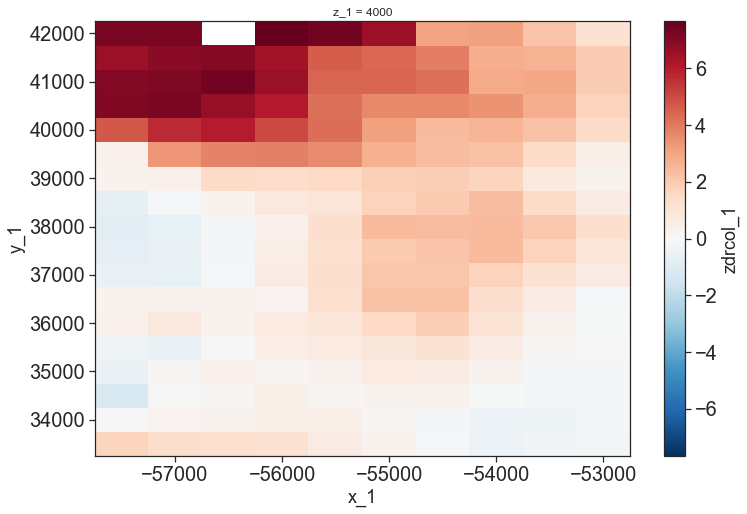

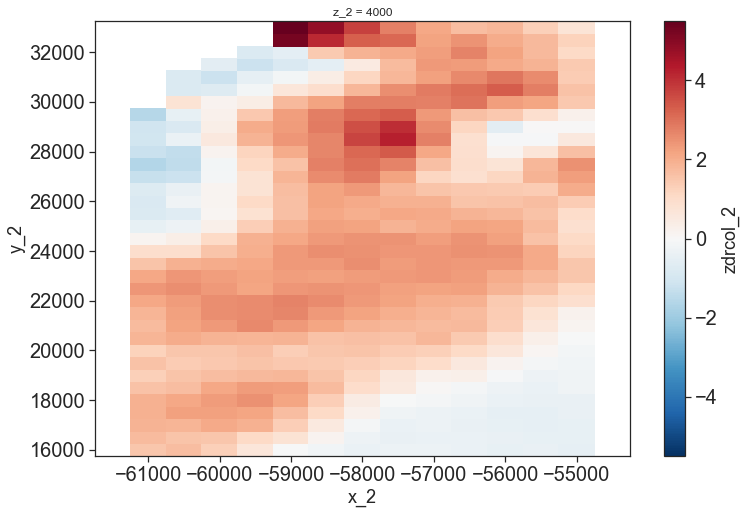

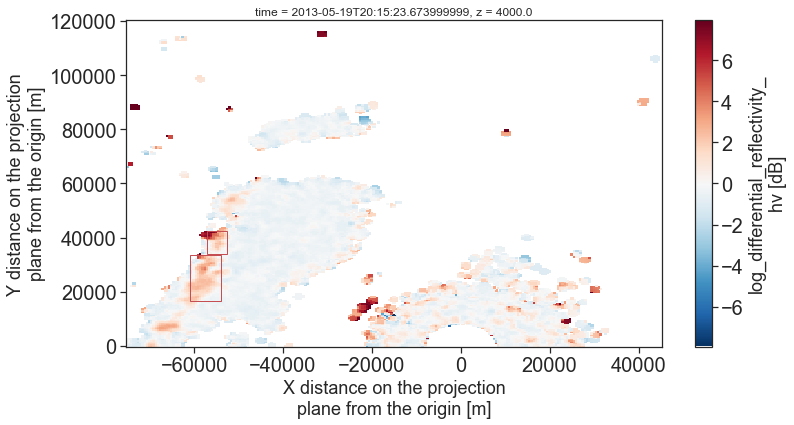

In [96]:
# Let's choose a time when more than 1 objects were present in segmented image

tt = zdr_intensity(data, final_bbox_data, dt_tmpstmps[3], "differential_reflectivity")

tt.zdrcol_1.isel(z_1=0).plot(x="x_1", y="y_1")
plt.show()
tt.zdrcol_2.isel(z_2=0).plot(x="x_2", y="y_2")
plt.show()

# another plot to show the bbox and zdr column object

fig, ax = plt.subplots(figsize=(12, 6))

data["differential_reflectivity"].isel(time=3).sel(z=4000).plot()

rect1 = patches.Rectangle(
    (-61000, 16500), 7000, 17000, linewidth=1, edgecolor="r", facecolor="none"
)
rect2 = patches.Rectangle(
    (-57000, 34000), 4500, 8500, linewidth=1, edgecolor="r", facecolor="none"
)

ax.add_patch(rect1)
ax.add_patch(rect2)

#### Let's define some functions that will be helpful in calculation of $Z_{DR}$ and $K_{DP}$ column statistics as well as visualization

In [14]:
def interactive_zdr_xr(data):
    """
    Input:
    -------
    data (xr.DataArray or xr.Dataset): Polarimetric field data within identified objects
                                        from segmented images
    
    Returns:
    -------
    interactive xarray plot with panel widget player to move across vertical levels
    """

    if isinstance(data, xr.DataArray):
        alt = pn.widgets.Player(
            name="alt",
            start=int(data.z[0]),
            end=int(data.z[-1]),
            step=int(data.z[1] - data.z[0]),
            loop_policy="loop",
            interval=100,
        )

        # alt = pn.widgets.Select(name='alt', value=15, options = list(np.arange(0,40,1)))

        zdr_plot = (
            data.isel(time=0)
            .interactive.sel(z=alt)
            .hvplot(colorbar=True, height=600, width=800, cmap=cmo.balance)
        )
        return zdr_plot

    elif isinstance(data, xr.Dataset):
        zdr_plot = []
        num_vars = len(data.data_vars)
        var_names = list(data.data_vars.variables)

        for i in range(len(var_names)):
            var = var_names[i]
            tmp_data = data[var].rename({data[var].dims[0]: "z"})
            dims = tmp_data.dims
            #             dims = data[var].dims
            alt = pn.widgets.Player(
                name="alt",
                start=int(tmp_data.coords[tmp_data.dims[0]][0]),
                end=int(tmp_data.coords[tmp_data.dims[0]][-1]),
                step=int(
                    tmp_data.coords[tmp_data.dims[0]][1]
                    - tmp_data.coords[tmp_data.dims[0]][0]
                ),  # dims[0] refers to z coordinate (which is listed first)
                # dims[0][1] refers to second z-level for that labeled obj
                loop_policy="loop",
                interval=100,
            )

            zdr_plot_tmp = tmp_data.interactive.sel(
                z=alt
            ).hvplot(  # we can use z as the dimension because we have already renamed our z-dimension as 'z'
                colorbar=True, height=600, width=800, cmap=cmo.balance
            )

            zdr_plot.append(zdr_plot_tmp)

        return zdr_plot

In [15]:
# Function for binning a single snapshot in time
# dat       = data array to bin (e.g., temperature distributed over 3D space)
# weights   = data array of the relative volumes of the cells in 3D space
# bin_edges = array of the edges of the bins (e.g. temperature bins)
# bin_mid   = array of the mid-points of the bins
def bin_snapshot(dat, weight, bin_edges, bin_mid):

    # Speed up by stacking over space
    dat = dat.stack(alldims=["x", "y", "z"])
    weight = weight.stack(alldims=["x", "y", "z"])

    # Bin the weight data into these variable bins
    # using the xarray groupby_bins method
    return weight.groupby_bins(
        dat.rename("groups"), bins=bin_edges, labels=bin_mid, include_lowest=True,
    ).sum()

In [16]:
def basic_stats(od_snapshot, var_list, qiles):
    # Pretty print the results:
    #     print("Raw statistics (not volume-weighted):")
    #     print(
    #         "%25s: %15s %15s %15s %15s %15s %15s %s"
    #         % ("Variable", "mean", "std", "mode", "1", "50", "99", "percentiles")
    #     )

    # Loop over variables computing statistics using xarray methods.
    # Variables need to be load because dask chunks are not compatible
    # with xarray quantiles function.
    for var in var_list:

        #         print("%25s:" % (od_snapshot[var].long_name), end=" ")

        # Data
        dats = getattr(od_snapshot, var).load()
        # Mean
        var_mean = dats.mean(keep_attrs=True)
        #         print("%10.4g" % (var_mean.values), end=" ")

        # Std
        var_std = dats.std(keep_attrs=True)
        #         print("%10.4g" % (var_std.values), end=" ")

        # Mode
        bin_edges = np.linspace(dats.min(), dats.max(), 512)
        bin_mid = (bin_edges[:-1] + bin_edges[1:]) / 2
        # Parallel switch
        if parallel:
            bin_snapshot_ = dask.delayed(bin_snapshot)

            # Needs to load first
            dat1 = [
                bin_snapshot_(
                    dats.sel(time=time).load(),
                    xr.ones_like(dats).sel(time=time).load(),
                    bin_edges,
                    bin_mid,
                )
                for time in dats["time"]
            ]

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                dat1 = dask.compute(dat1)[0]
        else:
            dat1 = [
                bin_snapshot(
                    dats.sel(time=time),
                    xr.ones_like(dats).sel(time=time),
                    bin_edges,
                    bin_mid,
                )
                for time in dats["time"]
            ]
        dat1 = xr.concat(dat1, "time").sum("time")
        var_mode = dat1["groups_bins"].where(dat1 == dat1.max(), drop=True)
        #         print([f'{val:10.4g}' for val in var_mode.values])
        #     print("%10.4g" % (var_mode.values), end=" ")

        # Qiles
        var_qiles = dats.quantile(qiles, keep_attrs=True)
        #         print(
        #             "%10.4g %10.4g %10.4g %s"
        #             % (
        #                 var_qiles.sel(quantile=qiles[0]).values,
        #                 var_qiles.sel(quantile=qiles[1]).values,
        #                 var_qiles.sel(quantile=qiles[2]).values,
        #                 od_snapshot[var].units,
        #             )
        #         )

        a = [
            od_snapshot[var].long_name,
            var_mean.values,
            var_std.values,
            var_mode.values,
            var_qiles.sel(quantile=qiles[0]).values,
            var_qiles.sel(quantile=qiles[1]).values,
            var_qiles.sel(quantile=qiles[2]).values,
        ]

        del dats

        return a

In [17]:
def zdr_stats_out(zdr_col_data, field, dt):

    df = pd.DataFrame()
    var_names = field
    col_names = ["Variable", "mean", "std", "mode", "1", "50", "99"]

    if isinstance(zdr_col_data, xr.DataArray):
        od_snapshot = zdr_col_data.to_dataset()
        stats = basic_stats(od_snapshot, var_list, qiles)
        tmp_df = pd.DataFrame([stats], columns=col_names, index=[[dt], [0]])
        df = df.append(tmp_df)

    elif isinstance(zdr_col_data, xr.Dataset):
        var_names = list(zdr_col_data.data_vars.variables)
        for i in range(len(var_names)):
            var = var_names[i]
            var_data = zdr_col_data[var].rename(field)
            dims = var_data.dims
            od_snapshot = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
            od_snapshot = od_snapshot.expand_dims("time")
            od_snapshot.attrs = {
                "long_name": "log_differential_reflectivity_hv",
                "units": "dB",
                "standard_name": "log_differential_reflectivity_hv",
                "coordinates": "elevation azimuth range",
            }
            od_snapshot = od_snapshot.to_dataset()

            stats = basic_stats(od_snapshot, var_list, qiles)

            tmp_df = pd.DataFrame([stats], columns=col_names, index=[[dt], [i]])

            df = df.append(tmp_df)

    return df

In [18]:
# Compute and print raw statistics

parallel = False

# Define the percentiles required:
qiles = [0.01, 0.50, 0.99]

# Define the variables required:
var_list = ["differential_reflectivity"]

stats_df = pd.DataFrame()

for i in range(len(dt_tmpstmps)):

    # obtain the zdr column data for all identified objects in a segmented file
    zdr_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "differential_reflectivity"
    )

    df = zdr_stats_out(zdr_col_data, "differential_reflectivity", dt_tmpstmps[i])
    stats_df = stats_df.append(df)

stats_df.index.names = ["time", ""]

# stats_df = stats_df.reset_index(level="time")

In [19]:
stats_df_new = stats_df.reset_index('time')[['mean','time']]

stats_df_new.astype({'mean': 'float64'}).dtypes

# convert column "a" of a DataFrame
# stats_df["mean"] = pd.to_numeric(stats_df["mean"])

mean           float64
time    datetime64[ns]
dtype: object

/anaconda3/envs/segmentation/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


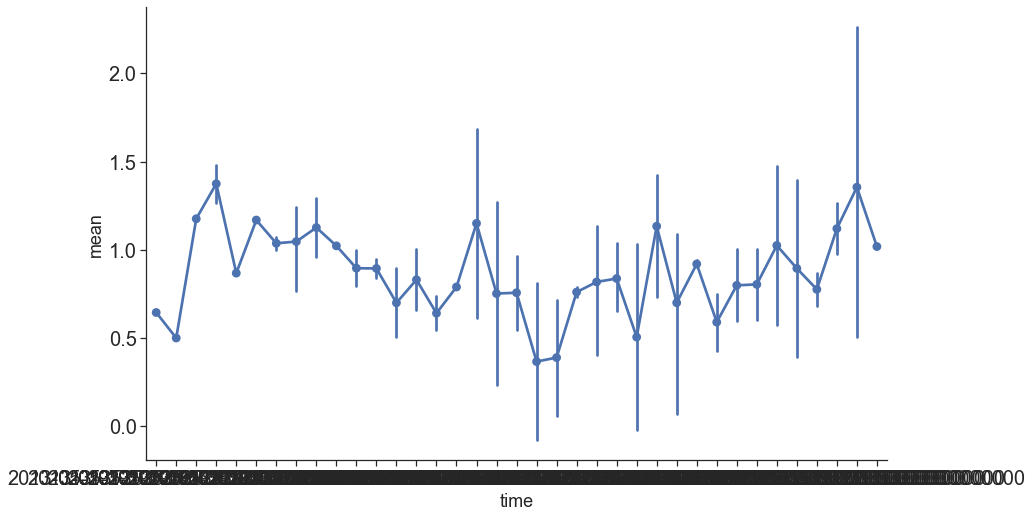

In [20]:
fg = seaborn.factorplot(x="time", y="mean", data=stats_df_new, kind="point", aspect=1)
fg.fig.set_figwidth(85)
fg.fig.set_figheight(8)

### Filter dual pol properties 

>Choose whether you want **mean or max** ZDR value at each z-level 

In [97]:
zdr_prop_alt = []
for i in range(len(dt_tmpstmps)):
    zdr_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "differential_reflectivity"
    )
    
    try:
        zdr_col_data = zdr_col_data.where(zdr_col_data > 1)

        if isinstance(zdr_col_data, xr.DataArray):
            #         print(zdr_col_data)
            zdr_prop_alt.append(zdr_col_data.mean(dim=["x", "y"]))
        elif isinstance(zdr_col_data, xr.Dataset):
            var_names = list(zdr_col_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = zdr_col_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
                tmp = tmp.mean(dim=["x", "y"])
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                #             print(tmp)
                zdr_prop_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass

#     huh = huh.append(zdr_col_data.mean(dim=['x','y']))

In [99]:
# concatenate list of dataarrays into a single dataarray
full_zdr_prop_alt_da = xr.concat(zdr_prop_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_zdr_prop_alt = full_zdr_prop_alt_da.to_dataframe()
full_zdr_prop_alt = full_zdr_prop_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_zdr_prop_alt["hue"] = full_zdr_prop_alt["z"].astype("category")
full_zdr_prop_alt

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


,z,time,differential_reflectivity,hue
0,4000.0,2013-05-19 20:02:36.054999999,2.154295,4000.0
1,4000.0,2013-05-19 20:06:52.065000000,1.979614,4000.0
2,4000.0,2013-05-19 20:11:07.271999999,2.525284,4000.0
3,4000.0,2013-05-19 20:15:23.000000000,3.297743,4000.0
4,4000.0,2013-05-19 20:15:23.000000000,2.079807,4000.0
...,...,...,...,...
809,9000.0,2013-05-19 22:27:38.000000000,NaN,9000.0
810,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
811,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
812,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0


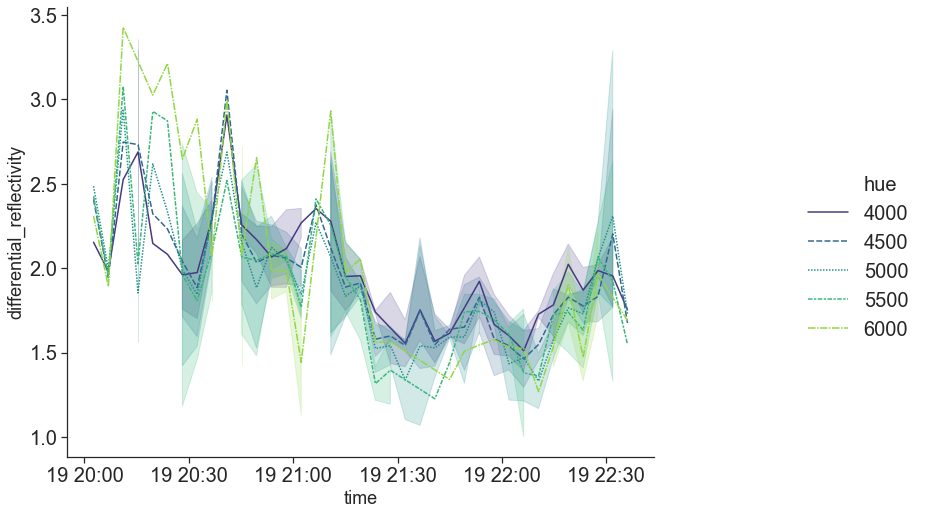

In [23]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_zdr_prop_alt,
    kind="line",
    hue="hue",
    hue_order=[4000, 4500, 5000, 5500, 6000],
    x="time",
    y="differential_reflectivity",
    palette="viridis",
    style="hue",
    style_order=[4000, 4500, 5000, 5500, 6000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
    #     markers=True
)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)

In [24]:
# we can also use hvplot to plot datarray
full_zdr_prop_alt_da.hvplot(cmap="viridis")

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/toolz/functoolz.py:488: RuntimeWarning: All-NaN slice encountered
  ret = f(ret)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


:Image   [time,z]   (differential_reflectivity)

### Let's quickly plot the equivalent diameter to get a sense of ZDR column widths

In [179]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28

In [248]:
# Load data from lasso analysis generated flash stats csv file using lmatools
lasso = '../data/interim/flash_stats.csv'

lasso_data = pd.read_csv(lasso, usecols=[0, 2])
lasso_data = lasso_data[0:-1]
lasso_data.columns = ['time', 'number']

lasso_data.index = pd.to_datetime(lasso_data['time'])
lasso_data = lasso_data.drop(columns=['time'])
lasso_data = lasso_data.rename({'number':'total flash rate'},axis=1)

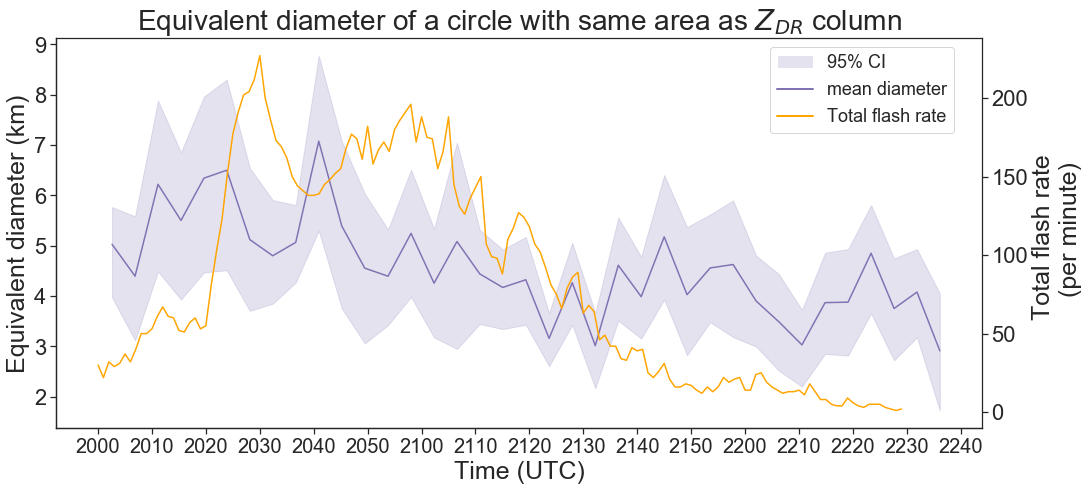

In [261]:
# fig = plt.figure(figsize=(12,12))

eq_dia_df = final_bbox_data.sort_index(level='altitude').reset_index('time')
eq_dia_df['equivalent_diameter'] = eq_dia_df['equivalent_diameter']*0.5

g = seaborn.relplot(
    data=eq_dia_df,
    kind="line",
#     hue="hue",
#     hue_order=[4000, 4500, 5000, 5500, 6000],
    x="time",
    y="equivalent_diameter",
    color='m',
#     palette="tab10",
#     style="hue",
#     style_order=[4000, 4500, 5000, 5500, 6000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
#     ci = None,
#     markers=True,
#     dashes=True
)

g.fig.set_figwidth(20)
g.fig.set_figheight(8)
g.set_ylabels('Equivalent diameter (km)')
g.set_xticklabels(dt_tmpstmps)
g.set_xlabels('Time (UTC)')
g.ax.set_title('Equivalent diameter of a circle with same area as $Z_{DR}$ column')

g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
# plt.legend(loc='upper right')

# g.add_legend()

# leg = g._legend
# leg.set_bbox_to_anchor([0.7, 1])  # coordinates of lower left of bounding box
# leg._loc = 2  # if required you can set the loc


ax2 = g.ax.twinx()

with pd.plotting.plot_params.use('x_compat', True):
    fr = ax2.plot(lasso_data,label='Total flash rate',c='orange')
    
ax2.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%H%M'))

ax2.set_ylabel('Total flash rate \n (per minute)')

legend_elements = [Patch(facecolor='#e5e2ef', label='95% CI'),
                   Line2D([0], [0], color='m', lw=2, label='mean diameter'),
                  Line2D([0], [0], color='orange', lw=2, label='Total flash rate'),
                  ]

g.ax.legend((legend_elements[0],legend_elements[1],legend_elements[2]),('95% CI','mean diameter','Total flash rate'),
            bbox_to_anchor=(0.48, 0.5, 0.5, 0.5), prop={'size': 18})

# g.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/ZDR_col_width.png',dpi=300)

### Let's also try plotting $Z_{DR}$ column volume at each z-level (grids with $Z_{DR}$ > 1dB only)

In [25]:
zdr_vol_alt = []
for i in range(len(dt_tmpstmps)):
    zdr_col_data = zdr_intensity(
        data, final_bbox_data, str(dt_tmpstmps[i]), "differential_reflectivity"
    )
    
    try:
        zdr_col_data = zdr_col_data.where(zdr_col_data > 1)

        if isinstance(zdr_col_data, xr.DataArray):
            #         print(zdr_col_data)
            zdr_vol_alt.append(zdr_col_data.count(dim=["x", "y"]) * 0.5**3)
        elif isinstance(zdr_col_data, xr.Dataset):
            var_names = list(zdr_col_data.data_vars.variables)
            for j in range(len(var_names)):
                var = var_names[j]
                var_data = zdr_col_data[var]
                dims = var_data.dims
                tmp = var_data.rename(dict(zip(dims, ("z", "y", "x"))))
                tmp = tmp.count(dim=["x", "y"]) * 0.5**3
                tmp = tmp.assign_coords({"time": dt_tmpstmps[i]})
                tmp = tmp.expand_dims("time")
                #             print(tmp)
                zdr_vol_alt.append(tmp)

    except AttributeError:
        # fails when there is no zdr column data 
        pass

#     huh = huh.append(zdr_col_data.mean(dim=['x','y']))

In [26]:
# concatenate list of dataarrays into a single dataarray
full_zdr_vol_alt_da = xr.concat(zdr_vol_alt, dim="time")

# convert dataarray to dataframe to plot data using seaborn
full_zdr_vol_alt = full_zdr_vol_alt_da.to_dataframe()
full_zdr_vol_alt = full_zdr_vol_alt.reset_index(level=["time", "z"])
# full_zdr_prop_alt

# add hue column in the dataframe
full_zdr_vol_alt["hue"] = full_zdr_vol_alt["z"].astype("category")
full_zdr_vol_alt

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


,z,time,differential_reflectivity,hue
0,4000.0,2013-05-19 20:02:36.054999999,20.000,4000.0
1,4000.0,2013-05-19 20:06:52.065000000,21.750,4000.0
2,4000.0,2013-05-19 20:11:07.271999999,47.375,4000.0
3,4000.0,2013-05-19 20:15:23.000000000,12.000,4000.0
4,4000.0,2013-05-19 20:15:23.000000000,37.125,4000.0
...,...,...,...,...
809,9000.0,2013-05-19 22:27:38.000000000,NaN,9000.0
810,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
811,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0
812,9000.0,2013-05-19 22:31:53.000000000,NaN,9000.0


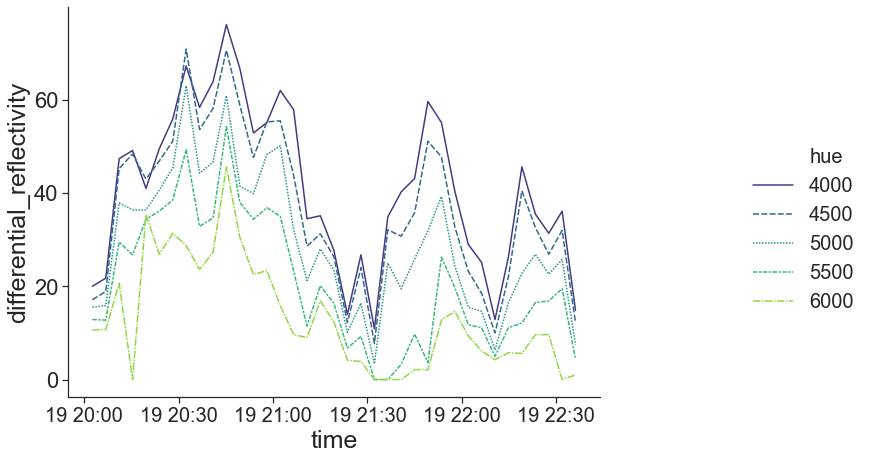

In [42]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_zdr_vol_alt,
    kind="line",
    hue="hue",
    hue_order=[4000, 4500, 5000, 5500, 6000],
    x="time",
    y="differential_reflectivity",
    palette="viridis",
    style="hue",
    style_order=[4000, 4500, 5000, 5500, 6000],
    height=5,
    aspect=1,
    facet_kws=dict(sharex=False),
    #     markers=True
)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)

Now, we want to sum up volumes of all ZDR column objects at a given altitude for a given time step

In [112]:
plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28

In [113]:
full_zdr_vol_alt = full_zdr_vol_alt.groupby(['z','time']).agg({'differential_reflectivity': sum}).reset_index()

In [114]:
full_zdr_vol_alt["Height above FZL (m)"] = (full_zdr_vol_alt["z"]-4000).astype("category")

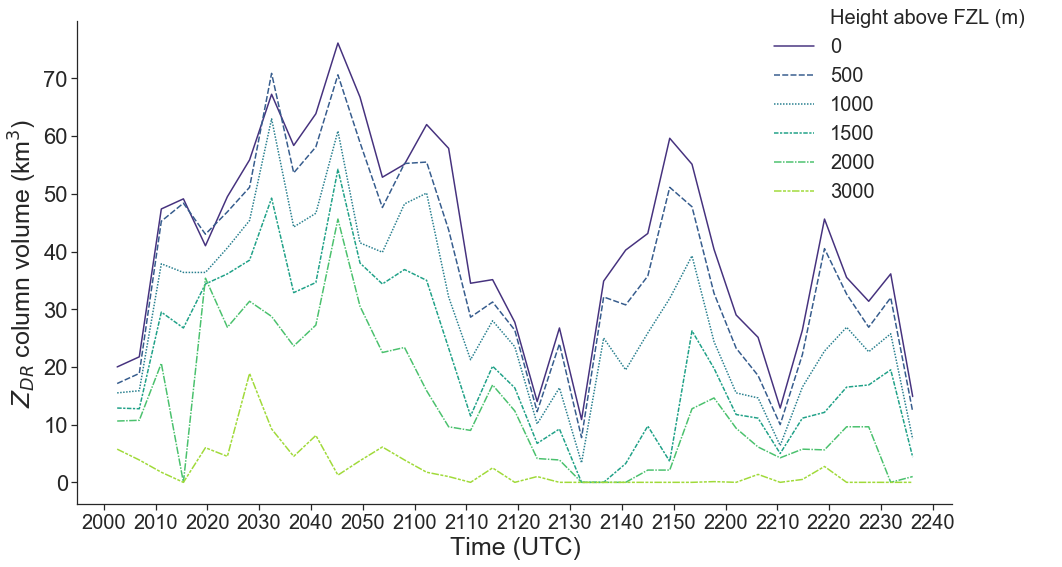

In [117]:
# fig = plt.figure(figsize=(12,12))
g = seaborn.relplot(
    data=full_zdr_vol_alt,
    kind="line",
    hue="Height above FZL (m)",
    hue_order=[0, 500, 1000, 1500, 2000, 3000],
    x="time",
    y="differential_reflectivity",
    palette="viridis",
    style="Height above FZL (m)",
    style_order=[0, 500, 1000, 1500, 2000, 3000],
    height=10,
    aspect=2.5,
    facet_kws=dict(sharex=False),
#     legend = False
    #     markers=True
)
g.fig.set_figwidth(15)
g.fig.set_figheight(8)
g.set_ylabels('$Z_{DR}$ column volume (km$^{3}$)')
g.set_xticklabels(dt_tmpstmps)
g.set_xlabels('Time (UTC)')

g.ax.xaxis.set_major_formatter(dates.DateFormatter("%H%M"))
g.ax.xaxis.set_major_locator(dates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
# plt.legend(loc='upper right')

leg = g._legend
leg.set_bbox_to_anchor([0.7, 1])  # coordinates of lower left of bounding box
leg._loc = 2  # if required you can set the loc

# g.fig.savefig(os.path.expanduser('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/zdrvol_diff_alts.png'),
#             bbox_inches='tight',dpi=300)

# plt.savefig(os.path.expanduser('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/zdr_kdp_col_vol_flash_initiation_within_obj/ZDR_col_vol_flash_initiations1.png'),
#             bbox_inches='tight',dpi=300)


#### But we can also use interactive xarray to visualize ZDR column objects

In [45]:
# Next, we want to visualize the data, so
# finally, store the interactive xarray plot in a new variable

zdr_anim_data = zdr_intensity(
    data, final_bbox_data, str(dt_tmpstmps[0]), "differential_reflectivity"
)

zdr_anim_data = zdr_anim_data.where(zdr_anim_data > 1)

all_zdr_objs = interactive_zdr_xr(zdr_anim_data)

# plot all the # objects in the new variable all_zdr_objs
# Please note that it will only pass when multiple objects
# are present in returned object. Therefore, try block below
try:
    print(len(all_zdr_objs))
except:
    pass

all_zdr_objs

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


In [244]:
# Violin plot for ZDR column data showing variance of ZDR col values at each z-level at which the column was identified by segmentation algorithm

zdr_anim_data = zdr_intensity(
    data, final_bbox_data, str(dt_tmpstmps[0]), "differential_reflectivity"
)

zdr_anim_data = zdr_anim_data.where(zdr_anim_data > 1)


if isinstance(zdr_anim_data, xr.DataArray):  # when only one zdr obj is present
    violin_plot = zdr_anim_data.hvplot.violin(
        "differential_reflectivity",
        by="z",
        color="z",
        cmap="Category20",
        height=500,
        width=1000,
    )

elif isinstance(zdr_anim_data, xr.Dataset):  # when multiple zdr objs are present
    var_names = list(zdr_anim_data.data_vars.variables)
    violin_plot = []
    for var in var_names:
        dims = zdr_anim_data[var].dims
        violin_plot.append(
            zdr_anim_data[var].hvplot.violin(
                var,
                by=zdr_anim_data[var].dims[0],
                color=zdr_anim_data[var].dims[0],
                cmap="Category20",
                height=500,
                width=1000,
            )
        )
violin_plot

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


:Violin   [z]   (differential_reflectivity)

In [58]:
zdr_anim_data = zdr_intensity(
    data, final_bbox_data, str(dt_tmpstmps[10]), "differential_reflectivity"
)

zdr_anim_data = zdr_anim_data.where(zdr_anim_data > 1)

if isinstance(zdr_anim_data, xr.DataArray):  # when only one zdr obj is present
    kde_plot = zdr_anim_data.hvplot.kde(
        "differential_reflectivity", by="z", alpha=0.5, height=500, width=900
    )

elif isinstance(zdr_anim_data, xr.Dataset):  # when multiple zdr objs are present
    var_names = list(zdr_anim_data.data_vars.variables)
    kde_plot = []
    for var in var_names:
        dims = zdr_anim_data[var].dims
        tmp = zdr_anim_data[var].rename({dims[0]:'z'})
        tmp = tmp.rename('differential_reflectivity')
        kde_plot.append(
            tmp.hvplot.kde(
                "differential_reflectivity", by="z", alpha=0.5, height=500, width=900
            )
        )
        
        
kde_plot[1]

:NdOverlay   [z]
   :Distribution   [differential_reflectivity]   (Density)

In [65]:
zdr_anim_data = zdr_intensity(
    data, final_bbox_data, str(dt_tmpstmps[3]), "differential_reflectivity"
)

zdr_anim_data = zdr_anim_data.where(zdr_anim_data > 1)

if isinstance(zdr_anim_data, xr.DataArray):  # when only one zdr obj is present
    bar_plot = zdr_anim_data.sel(z=4500).hvplot.hist(height=500, width=900)

elif isinstance(zdr_anim_data, xr.Dataset):  # when multiple zdr objs are present
    var_names = list(zdr_anim_data.data_vars.variables)
    bar_plot = []
    for var in var_names:
        dims = zdr_anim_data[var].dims
        tmp = zdr_anim_data[var].rename({dims[0]:'z'})
#         tmp = tmp.rename('differential_reflectivity')
        bar_plot.append(
            tmp.sel(z=4500).hvplot.hist(height=500, width=900)
        )
        
bar_plot[0]

:NdOverlay   [Element]
   :Histogram   [zdrcol_1]   (zdrcol_1_count)

### Calculate ZDR column volume 

> We still use segmented objects based on original PyART grids and their bbox region

> The difference being rather than calculating all pixels with a certain label in segmented objects </br>
now we calculate only the grid cells which have $Z_{DR}$ > 1 dB

In [245]:
def dualpol_gt_thresh_vol(data,bbox_data,dt,field,threshold):
    zdr_anim_data = zdr_intensity(
        data, bbox_data, str(dt), field
        )

    zdr_anim_data = zdr_anim_data.where(zdr_anim_data > threshold)


    if isinstance(zdr_anim_data, xr.DataArray):  # when only one zdr obj is present
        vol = zdr_anim_data.squeeze().count(dim=['z','y','x']) * 0.5**3
        return np.array(vol)

    elif isinstance(zdr_anim_data, xr.Dataset):  # when multiple zdr objs are present
        var_names = list(zdr_anim_data.data_vars.variables)
        vol = []
        for var in var_names:
            tmp_vol = zdr_anim_data[var].squeeze().count() * 0.5**3
            vol.append(tmp_vol)
        return np.sum(vol)

In [246]:
zdr_vol = []
for i in range(len(data.time)):
    tmp_zdr_vol = dualpol_gt_thresh_vol(data,final_bbox_data,dt_tmpstmps[i],'differential_reflectivity',1)
    zdr_vol.append(
        {'time':dt_tmpstmps[i],
         'vol': tmp_zdr_vol
        }
    )

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid v

AttributeError: 'NoneType' object has no attribute 'where'

In [247]:
zdr_vol_df = pd.DataFrame(zdr_vol)
zdr_vol_df = zdr_vol_df.set_index('time')

In [160]:
# zdr_vol_df.to_csv('zdr_vol_gt_1dB_pyart_based_segmentation')

### KDP column volume

In [73]:
data = xr.open_mfdataset(
    "/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/gridded_ktlx/*.nc",
    parallel=True,
)
data

<xarray.Dataset>
Dimensions:                      (nradar: 1, time: 42, x: 241, y: 241, z: 31)
Coordinates:
  * time                         (time) datetime64[ns] 2013-05-19T20:02:36.05...
  * x                            (x) float64 -7.5e+04 -7.45e+04 ... 4.5e+04
  * y                            (y) float64 0.0 500.0 ... 1.195e+05 1.2e+05
  * z                            (z) float64 0.0 500.0 ... 1.45e+04 1.5e+04
Dimensions without coordinates: nradar
Data variables:
    origin_latitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_longitude             (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    origin_altitude              (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    projection                   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    ProjectionCoordinateSystem   (time) int32 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1
    radar_latitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_longitude              (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_altitude               (time, nradar) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_time                   (time, nradar) datetime64[ns] dask.array<chunksize=(1, 1), meta=np.ndarray>
    radar_name                   (time, nradar) |S4 dask.array<chunksize=(1, 1), meta=np.ndarray>
    reflectivity                 (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    velocity                     (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_reflectivity    (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    spectrum_width               (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    differential_phase           (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    cross_correlation_ratio      (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    norm_coherent_power          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    unfolded_differential_phase  (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    phidp                        (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    kdp                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
    ROI                          (time, z, y, x) float32 dask.array<chunksize=(1, 31, 241, 241), meta=np.ndarray>
Attributes:
    Conventions:         CF/Radial instrument_parameters
    version:             1.3
    title:               
    institution:         
    references:          
    source:              
    history:             
    comment:             
    instrument_name:     KTLX
    original_container:  NEXRAD Level II
    vcp_pattern:         12

In [32]:
# after manual verification of all the KDP column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

# These are from new segmentation performed on kdp array on Nov 28, 2020
kdp_obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [8],
    [4],
    [7],
    [3, 8],
    [3],
    [4],
    [3],
    [2],
    [4, 6],
    [2],
    [1],
    [2],
    [5],
    [5],
    [2, 3],
    [4],
    [4],
    [2],
    [1],
    [2],
    [3, 4],
    [2],
    [3, 4],
    [3],
    [3],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [33]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

kdp_segmented_files = sorted(
    glob.glob("../data/processed/segmented_stacks/kdp/direct_array/*tiff")
)

# rad_files = sorted(glob.glob('path/to/KTLX_data/*V06'))
rad_files = sorted(
    glob.glob("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/*V06")
)
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [34]:
# Here, we create a dataframe which stores the bbox region coordinates and label values for kdp column objects
# NOTE: These kdp column objects were identified from the segmentation result using direct array
# and not by reding files using the AICSImage reader.

final_kdp_df = pd.DataFrame()
for i in range(len(kdp_segmented_files)):

    cell_seg_reader = io.imread(kdp_segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    # cell_seg = label(cell_seg[:,::-1,:])
    props = regionprops_table(seg, properties=["bbox", "bbox_area", "label"])

    df = pd.DataFrame(props)
    #     df.drop(labels=['time'],axis=1,inplace=True)

    df["time"] = dt_tmpstmps[i]
    df.index = df["time"]
    df.drop(labels=["time"], axis=1, inplace=True)

    df_sel = df[df["label"].isin(kdp_obj_interest[i])]
    # append zdr_col info df for current time step to the final_df
    final_kdp_df = final_kdp_df.append(df_sel,)

In [69]:
# create a list of altitudes to be fed as pandas index
# the values here were known to us because of segmentation z-level limits
alts = np.arange(4000, 11500, 500)


mega_tt = pd.DataFrame()
for i in range(len(kdp_segmented_files)):
    cell_seg_reader = io.imread(kdp_segmented_files[i])
    cell_seg = cell_seg_reader
    seg = label(cell_seg)
    seg = np.fliplr(seg)

    tt = pd.DataFrame()
    for j in range(seg.shape[0]):  # loop for moving through all z-levels (4000 to 11000 m)

        try:  # fails when there is no data to be measured in the segmented file

            # create a temporary dataframe to store region props at each z-level
            tmp = pd.DataFrame(
                regionprops_table(
                    seg[j, :, :], properties=["bbox", "bbox_area", "area", "label"]
                )
            )

            try:  # fails when no pixel with label of interest is left at a certain altitude level

                for k in range(
                    len(kdp_obj_interest[i])
                ):  # loop to account for all segmented objects (if multiple objects exist in a segmented file)

                    # filter out the row from tmp dataframe that corresponds to a particular object label
                    tmp1 = tmp[tmp["label"] == kdp_obj_interest[i][k]]

                    # create a multi-index dataframe to store info about time, obj label, and z-level of region props
                    # this will enable us to calculate ZDR/KDP intensity within accurately identified bbox regions at each z-level
                    tmp2 = pd.DataFrame(
                        tmp1.iloc[:, :6].values,
                        index=[[dt_tmpstmps[i]], [kdp_obj_interest[i][k]], [alts[j]]],
                        columns=tmp.columns[:6],
                    )
                    tt = tt.append(tmp2)
            except:
                pass
        except IndexError:
            pass
    

    # finally, append dataframe at each vertical level to obtain one dataframe per time (for all objects and z-levels)
    mega_tt = mega_tt.append(tt)



# rename indices of final dataframe for more clarity to user
mega_tt.index.names = ["time", "label", "altitude"]

# Next, we want to reorder the indices to have all region props for each object listed out sequentially
# before proceeding with the next object (if there exists any) in the same segmented file

# check out how max/min function works on nested lists at the following link
# https://stackoverflow.com/a/55846534/12538451
final_bbox_data_kdp = mega_tt.reindex(np.arange([max((y for y in x if y is not np.nan), default=np.nan) for x in zip(*kdp_obj_interest)][0]), level=1)

In [95]:
kdp_vol = []
for i in range(len(data.time)):
    try:
        tmp_kdp_vol = dualpol_gt_thresh_vol(data,final_bbox_data_kdp,dt_tmpstmps[i],'kdp',0.75)
        kdp_vol.append(
        {'time':dt_tmpstmps[i],
         'vol': tmp_kdp_vol
        }
    )
    except AttributeError:
        pass
    

/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/anaconda3/envs/segmentation/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid v

In [96]:
kdp_vol_df = pd.DataFrame(kdp_vol)
kdp_vol_df = kdp_vol_df.set_index('time')

In [93]:
# kdp_vol_df.to_csv('kdp_vol_gt_0.75degkm_pyart_based_segmentation')

### JUNK STUFF

Just to check the labels of segmented and labeled objects

In [271]:
from glob import glob

import dask.array as da
import numpy as np
from aicsimageio import AICSImage
from dask import delayed
from skimage import measure
from skimage.io.collection import alphanumeric_key

filenames = sorted(
    glob("../data/processed/segmented_stacks/zdr/direct_array/*tiff"),
    key=alphanumeric_key,
)
# read the first file to get the shape and dtype
# ASSUMES THAT ALL FILES SHARE THE SAME SHAPE/TYPE
sample = AICSImage(filenames[0]).data[0, 0, :, :, :]

lazy_aicsimage = delayed(AICSImage)  # lazy reader
lazy_arrays = [lazy_aicsimage(fn) for fn in filenames]
dask_arrays = [
    da.from_delayed(delayed_reader, shape=sample.shape, dtype=sample.dtype)
    for delayed_reader in lazy_arrays
]
# Stack into one large dask.array
stack = da.stack(dask_arrays, axis=0)
stack.shape  # (nfiles, nz, ny, nx)

# in jupyter notebook the repr of a dask stack provides a useful visual:
stack

,Array,Chunk
Bytes,36.59 MB,871.22 kB
Shape,"(42, 15, 241, 241)","(1, 15, 241, 241)"
Count,126 Tasks,42 Chunks
Type,uint8,numpy.ndarray


In [1]:
import napari

# with napari.gui_qt():
#     # specify contrast_limits and is_pyramid=False with big data
#     # to avoid unecessary computations
#     napari.view_image(stack, contrast_limits=[0,2000])

%gui qt

In [98]:
# This will create a napari viewer for the entire 4D (t,x,y,z) stack created for segmented images

import matplotlib.cm as cm
import napari
import pyart
from dask_image.imread import imread
from skimage import measure
from vispy.color import Colormap

# stack = imread("/Users/sharm261/Desktop/mount/May_19_2013_all_stuff/stack_images_kdp/segmented_stacks/*.tiff")
stack = imread("/Users/ms/Desktop/mount/May_19_2013_all_stuff/stack_images_zdr/21_06_34/*.tiff")

# sicne napari has limited colormaps and we want to use our custom colormap
cmap = cm.get_cmap("pyart_HomeyerRainbow", 15)
rgb_list = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    rgb_list.append(rgb)
rgb_list[0] = (0, 0, 0)

cmap = Colormap(rgb_list)

# define a function which reads only the last three dimensions since our stacked object is 4D
# concept credit: https://napari.org/tutorials/dask


def last3dims(f):
    # this is just a wrapper because the pycudadecon function
    # expects ndims==3 but our blocks will have ndim==4
    def func(array):
        return f(array[0])[None, ...]

    return func


label = last3dims(measure.label)

labeled = stack.map_blocks(label)

with napari.gui_qt():
    napari.view_image(
        labeled, contrast_limits=[0, 15], colormap=("HomeyerRainbow", cmap)
    )


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/anaconda3/envs/segmentation/lib/python3.6/site-packages/napari/utils/dask_utils.py:173: UserWarning: For best performance with Dask arrays in napari, please upgrade Dask to v2.15.0 or later. Current version is 2.9.0
  'For best performance with Dask arrays in napari, please '
